In [1]:
import sys
import spotipy
import yaml
import spotipy.util as util
from pprint import pprint
import json
import argparse
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns
from yellowbrick.cluster import KElbowVisualizer
from kneed import KneeLocator
import plotly.graph_objects as go
from plotly.subplots import make_subplots
sns.set()

## Spotipy Credentials and API Calls

In [2]:
# Get Spotipy credentials from config
def load_config():
    stream = open('config.yaml')
    user_config = yaml.load(stream, Loader=yaml.FullLoader)
    return user_config

user_config = load_config()

In [46]:
# Initialize Spotify API token
token = util.prompt_for_user_token(user_config['username'],  client_id=user_config['client_id'], client_secret=user_config['client_secret'], redirect_uri=user_config['redirect_uri'])
sp = spotipy.Spotify(auth=token)

In [13]:
# A function to extract track names and URIs from a playlist
def get_playlist_info(username, playlist_uri):
    # initialize vars
    offset = 0
    tracks, uris, names, artists = [], [], [], []

    # get playlist id and name from URI
    playlist_id = playlist_uri.split(':')[2]
    playlist_name = sp.user_playlist(username, playlist_id)['name']

    # get all tracks in given playlist (max limit is 100 at a time --> use offset)
    while True:
        results = sp.user_playlist_tracks(username, playlist_id, offset=offset)
        tracks += results['items']
        if results['next'] is not None:
            offset += 100
            if(offset%500 == 0):
                print(offset, end=" ")
        else:
            break
        
    # get track metadata
    for track in tracks:
        names.append(track['track']['name'])
        artists.append(track['track']['artists'][0]['name'])
        uris.append(track['track']['uri'])
    
    return playlist_name, names, artists, uris

In [53]:
# Extract features from each track in a playlist
def get_features_for_playlist(df, names, artists, uris):
    
    i = 0
    # iterate through each track to get audio features and save data into dataframe
    for name, artist, track_uri in zip(names, artists, uris):
        if(i<6569):
            i+=1
            continue
        if(i!=0  and i%500==0):
            print(i,end=" ")
        i+=1
        # print(json.dumps(track_uri, indent=4))              
        # ^ DEBUG STATEMENT ^
        
        try:
            # access audio features for given track URI via spotipy 
            audio_features = sp.audio_features(track_uri)

            # get relevant audio features
            feature_subset = [audio_features[0][col] for col in df.columns if col not in ["name", "artist", "track_URI", "playlist"]]

            # compose a row of the dataframe by flattening the list of audio features
            row = [name, artist, track_uri, *feature_subset, playlist_name]
            df.loc[len(df.index)] = row
        except:
            continue
    return df

In [108]:
# df = pd.DataFrame(columns=['name', 'artist', 'track_URI', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence', 'playlist'])
df = pd.read_csv("data.csv")

In [50]:
df.columns

Index(['name', 'artist', 'track_URI', 'acousticness', 'danceability', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo',
       'valence', 'playlist'],
      dtype='object')

In [23]:
# get all track metadata from given playlist
playlist_name, names, artists, uris = get_playlist_info(user_config['username'], 'spotify:playlist:5S8SJdl1BDc0ugpkEvFsIL')

500 1000 1500 2000 2500 3000 3500 4000 4500 5000 5500 6000 6500 7000 7500 8000 8500 9000 9500 

In [ ]:
# df = get_features_for_playlist(df, user_config['username'], 'spotify:playlist:5S8SJdl1BDc0ugpkEvFsIL')
df = get_features_for_playlist(df, names, artists, uris)
df

In [110]:
df.to_csv("data.csv", index=False)

In [57]:
df.shape

(9965, 13)

In [58]:
df.head()

,name,artist,track_URI,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,playlist
0,...Ready For It?,Taylor Swift,spotify:track:7zgqtptZvhf8GEmdsM2vp2,0.0665,0.615,0.779,0.000000,0.1550,-6.454,0.1350,160.000,0.453,The Longest Playlist on Spotify® (Official)
1,Life Changes,Thomas Rhett,spotify:track:4Vxu50qVrQcycjRyJQaZLC,0.1000,0.687,0.845,0.000000,0.0452,-4.370,0.0576,87.972,0.809,The Longest Playlist on Spotify® (Official)
2,24K Magic,Bruno Mars,spotify:track:6b8Be6ljOzmkOmFslEb23P,0.0340,0.818,0.803,0.000000,0.1530,-4.282,0.0797,106.970,0.632,The Longest Playlist on Spotify® (Official)
3,Galway Girl,Ed Sheeran,spotify:track:0afhq8XCExXpqazXczTSve,0.0735,0.624,0.876,0.000000,0.3270,-3.374,0.1000,99.943,0.781,The Longest Playlist on Spotify® (Official)
4,Photograph,Ed Sheeran,spotify:track:1HNkqx9Ahdgi1Ixy2xkKkL,0.6070,0.614,0.379,0.000464,0.0986,-10.480,0.0476,107.989,0.201,The Longest Playlist on Spotify® (Official)


In [59]:
df.duplicated(keep=False).sum()

42

In [109]:
df = df.drop_duplicates()
df.shape

(9944, 13)

In [107]:
df.describe()

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,9944.000000,9944.000000,9944.000000,9944.000000,9944.000000,9944.000000,9944.000000,9944.000000,9944.000000
mean,0.238767,0.567864,0.651672,0.099204,0.185019,-7.693482,0.069472,120.478207,0.473125
std,0.290991,0.166132,0.225201,0.246092,0.153860,4.440301,0.074665,28.199625,0.249016
min,0.000000,0.000000,0.000000,0.000000,0.000000,-53.436000,0.000000,0.000000,0.000000
25%,0.015700,0.467000,0.510000,0.000000,0.094000,-9.159000,0.034000,99.967000,0.274000
50%,0.096500,0.581000,0.696000,0.000034,0.122000,-6.510500,0.044050,119.972000,0.468000
75%,0.383000,0.686000,0.829000,0.008955,0.227000,-4.884000,0.069700,138.015500,0.670000
max,0.995000,0.980000,1.000000,0.999000,0.988000,-0.276000,0.957000,240.107000,0.990000


## Principal Component Analysis (PCA)

In [61]:
non_features = ['name', 'artist', 'track_URI', 'playlist']
track_info = df[non_features]
df_X = df.drop(columns=non_features)
df_X.head()

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
0,0.0665,0.615,0.779,0.000000,0.1550,-6.454,0.1350,160.000,0.453
1,0.1000,0.687,0.845,0.000000,0.0452,-4.370,0.0576,87.972,0.809
2,0.0340,0.818,0.803,0.000000,0.1530,-4.282,0.0797,106.970,0.632
3,0.0735,0.624,0.876,0.000000,0.3270,-3.374,0.1000,99.943,0.781
4,0.6070,0.614,0.379,0.000464,0.0986,-10.480,0.0476,107.989,0.201


In [62]:
scaler = StandardScaler()
X_std = scaler.fit_transform(df_X)

In [63]:
pca = PCA()
pca.fit(X_std);

In [64]:
# The attribute shows how much variance is explained by each of the nine features
evr = pca.explained_variance_ratio_
evr

array([0.33098355, 0.15504223, 0.12480872, 0.1060372 , 0.08854474,
       0.08555057, 0.05059437, 0.03881774, 0.01962089])

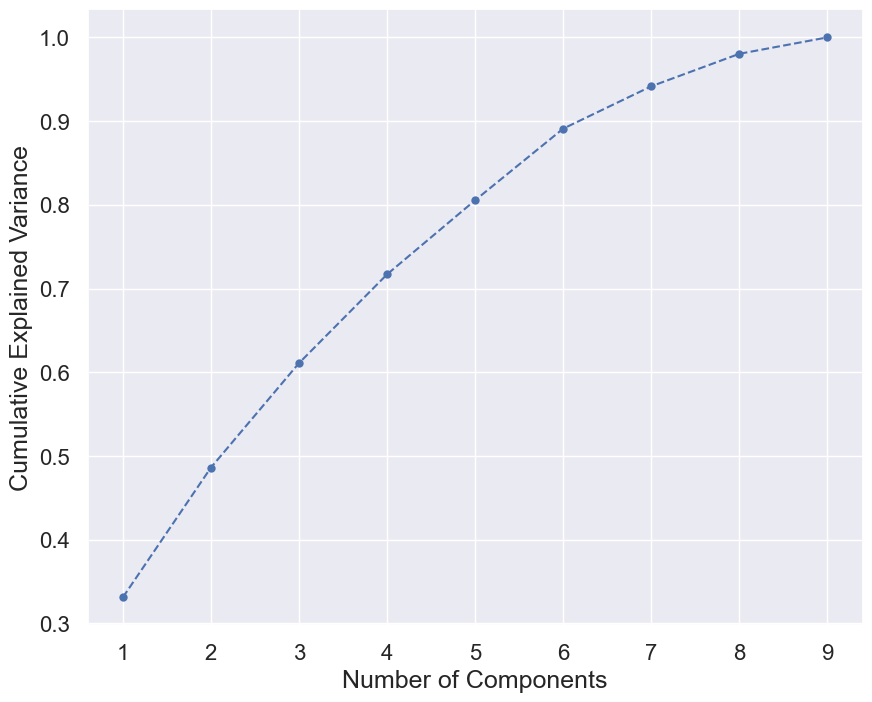

In [66]:
fig = plt.figure(figsize=(10,8))
plt.plot(range(1, len(df_X.columns)+1), evr.cumsum(), marker='o', linestyle='--')
plt.xlabel('Number of Components', fontsize=18)
plt.ylabel('Cumulative Explained Variance',fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
fig = plt.savefig("./visualizations/cumulative_variance_plot.png")
plt.show()

In [67]:
for i, exp_var in enumerate(evr.cumsum()):
    if exp_var >= 0.8:
        n_comps = i + 1
        break
print("Number of components:", n_comps)
pca = PCA(n_components=n_comps)
pca.fit(X_std)
scores_pca = pca.transform(X_std)

Number of components: 5


## K-Means Clustering

Finding the elbow point of the WCSS (within cluster sum of squares) curve using the YellowBrick `KElbowVisualizer`

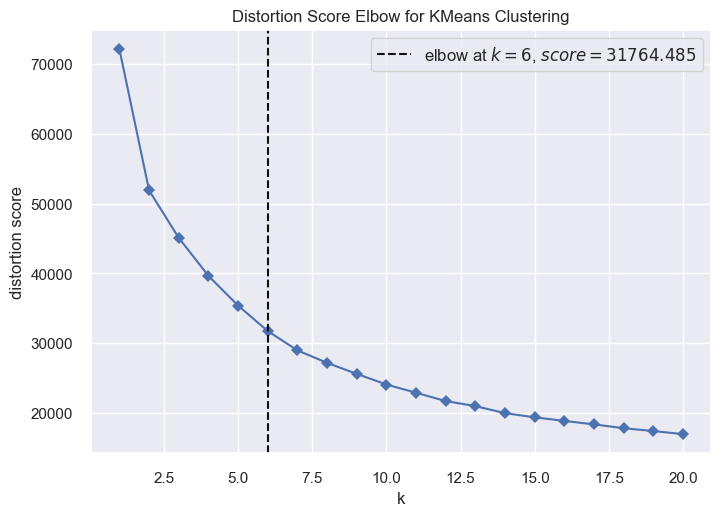

Optimal number of clusters: 6


In [68]:
visualizer = KElbowVisualizer(KMeans(init='k-means++', random_state=42), k=(1,21), timings=False)
visualizer.fit(scores_pca)
visualizer.show()
n_clusters = visualizer.elbow_value_
print("Optimal number of clusters:", n_clusters)

Finding the elbow point of the WCSS (within cluster sum of squares) curve using the kneed `KneeLocator`

In [69]:
wcss = []
max_clusters = 21
for i in range(1, max_clusters):
    kmeans_pca = KMeans(i, init='k-means++', random_state=42)
    kmeans_pca.fit(scores_pca)
    wcss.append(kmeans_pca.inertia_)
n_clusters = KneeLocator([i for i in range(1, max_clusters)], wcss, curve='convex', direction='decreasing').knee
print("Optimal number of clusters", n_clusters)

Optimal number of clusters 6


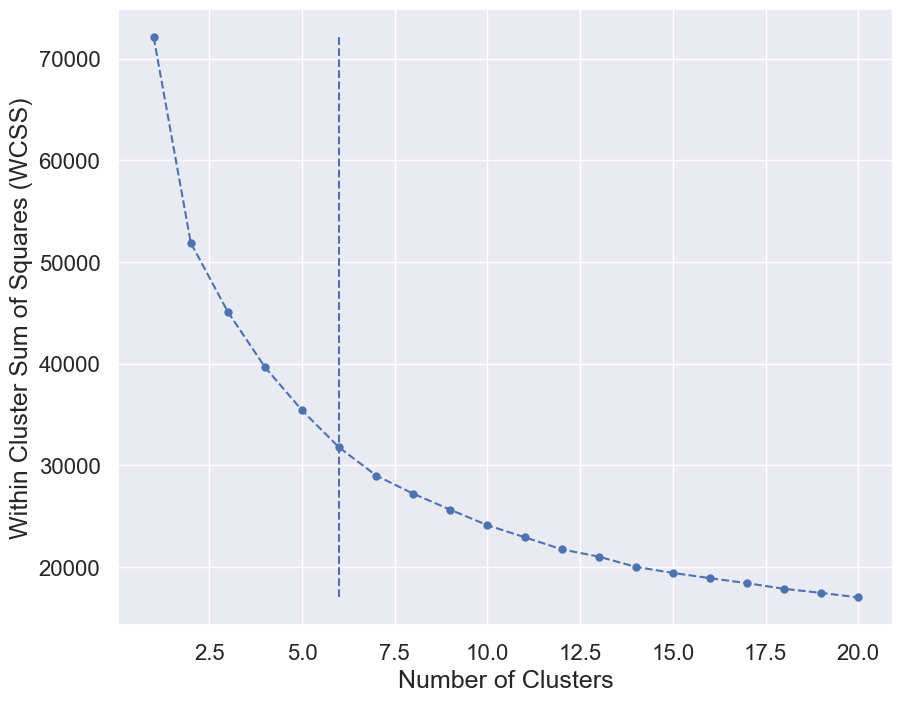

In [70]:
fig = plt.figure(figsize=(10,8))
plt.plot(range(1, 21), wcss, marker='o', linestyle='--')
plt.vlines(KneeLocator([i for i in range(1, max_clusters)], wcss, curve='convex', direction='decreasing').knee, ymin=min(wcss), ymax=max(wcss), linestyles='dashed')
plt.xlabel('Number of Clusters', fontsize=18)
plt.ylabel('Within Cluster Sum of Squares (WCSS)', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
fig.savefig("./visualizations/num_clusters.png")
plt.show()

In [101]:
kmeans_pca = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
kmeans_pca.fit(scores_pca);

## Analysis and Visualization

In [89]:
df_seg_pca_kmeans = pd.concat([df_X.reset_index(drop=True), pd.DataFrame(scores_pca)], axis=1)
df_seg_pca_kmeans.columns.values[(-1*n_comps):] = ["Component " + str(i+1) for i in range(n_comps)]
df_seg_pca_kmeans['Cluster'] = kmeans_pca.labels_
df_seg_pca_kmeans.head()

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,Component 1,Component 2,Component 3,Component 4,Component 5,Cluster
0,0.0665,0.615,0.779,0.000000,0.1550,-6.454,0.1350,160.000,0.453,-1.103692,0.561025,0.069165,1.379352,-0.289975,3
1,0.1000,0.687,0.845,0.000000,0.0452,-4.370,0.0576,87.972,0.809,-1.584092,-1.306910,0.079066,-0.890713,-0.678073,2
2,0.0340,0.818,0.803,0.000000,0.1530,-4.282,0.0797,106.970,0.632,-1.712936,-0.921599,0.487957,-0.497414,-0.400337,2
3,0.0735,0.624,0.876,0.000000,0.3270,-3.374,0.1000,99.943,0.781,-1.802980,0.113863,1.002629,-0.885143,0.337400,7
4,0.6070,0.614,0.379,0.000464,0.0986,-10.480,0.0476,107.989,0.201,1.739287,-1.089590,-0.292321,0.194143,0.324685,1


C:\Users\prana\AppData\Local\Temp\ipykernel_3792\1201196075.py:4: UserWarning:


The palette list has fewer values (7) than needed (10) and will cycle, which may produce an uninterpretable plot.



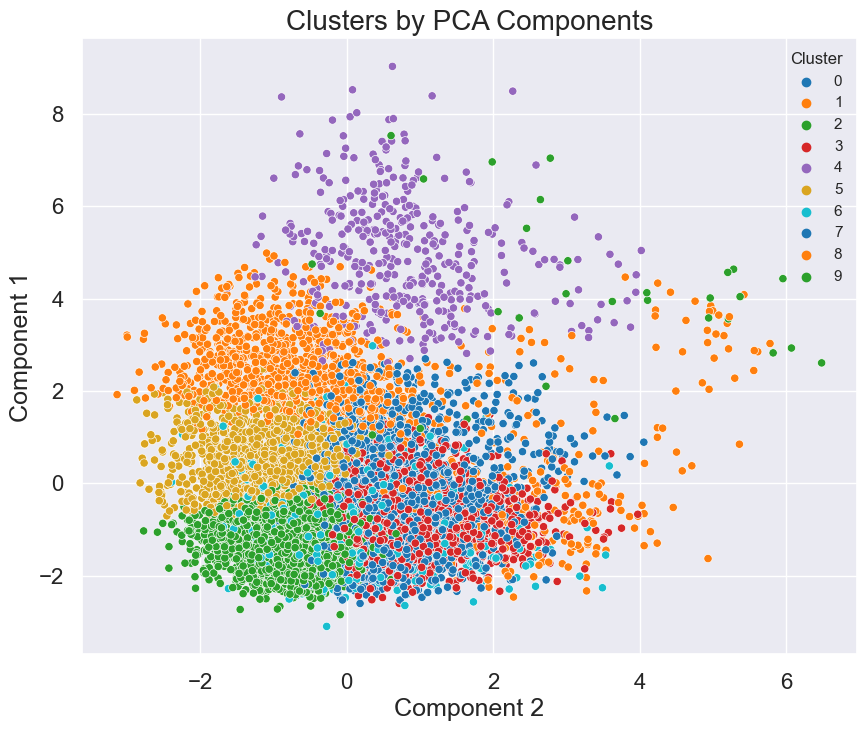

In [90]:
x = df_seg_pca_kmeans['Component 2']
y = df_seg_pca_kmeans['Component 1']
fig = plt.figure(figsize=(10, 8))
sns.scatterplot(df_seg_pca_kmeans,x = 'Component 2', y='Component 1', hue='Cluster', palette = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'goldenrod', 'tab:cyan'])
plt.title('Clusters by PCA Components', fontsize=20)
plt.xlabel("Component 2", fontsize=18)
plt.ylabel("Component 1", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()
fig.savefig("./visualizations/clusters-2d.png")

In [91]:
df['Cluster'] = df_seg_pca_kmeans['Cluster']
df

C:\Users\prana\AppData\Local\Temp\ipykernel_3792\129264112.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,name,artist,track_URI,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,playlist,Cluster
0,...Ready For It?,Taylor Swift,spotify:track:7zgqtptZvhf8GEmdsM2vp2,0.06650,0.615,0.779,0.000000,0.1550,-6.454,0.1350,160.000,0.453,The Longest Playlist on Spotify® (Official),3.0
1,Life Changes,Thomas Rhett,spotify:track:4Vxu50qVrQcycjRyJQaZLC,0.10000,0.687,0.845,0.000000,0.0452,-4.370,0.0576,87.972,0.809,The Longest Playlist on Spotify® (Official),2.0
2,24K Magic,Bruno Mars,spotify:track:6b8Be6ljOzmkOmFslEb23P,0.03400,0.818,0.803,0.000000,0.1530,-4.282,0.0797,106.970,0.632,The Longest Playlist on Spotify® (Official),2.0
3,Galway Girl,Ed Sheeran,spotify:track:0afhq8XCExXpqazXczTSve,0.07350,0.624,0.876,0.000000,0.3270,-3.374,0.1000,99.943,0.781,The Longest Playlist on Spotify® (Official),7.0
4,Photograph,Ed Sheeran,spotify:track:1HNkqx9Ahdgi1Ixy2xkKkL,0.60700,0.614,0.379,0.000464,0.0986,-10.480,0.0476,107.989,0.201,The Longest Playlist on Spotify® (Official),1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9960,Funeral For A Friend / Love Lies Bleeding,Elton John,spotify:track:4UFlPCB4THnQ9TlPHqIQow,0.01980,0.410,0.761,0.084700,0.2470,-8.507,0.0465,138.712,0.193,The Longest Playlist on Spotify® (Official),NaN
9961,Fool's Overture,Supertramp,spotify:track:5pSSEkT0963muzzIjsVkrs,0.31300,0.406,0.306,0.007900,0.0727,-10.482,0.0372,135.272,0.073,The Longest Playlist on Spotify® (Official),NaN
9962,Heart of the Sunrise - 2003 Remaster,Yes,spotify:track:7gC6Rbllqf1yXNC02e5jz2,0.01740,0.362,0.507,0.216000,0.1130,-11.229,0.0394,146.641,0.456,The Longest Playlist on Spotify® (Official),NaN
9963,Venus And Mars / Rock Show / Jet - Live / Rema...,Paul McCartney,spotify:track:6Ff77WXC58MkhLE5A1qgY1,0.08870,0.331,0.733,0.001740,0.9470,-8.671,0.0468,128.512,0.380,The Longest Playlist on Spotify® (Official),NaN


In [ ]:
for i in range(n_clusters):
    result = sp.user_playlist_create(user_config['username'], 'cluster'+str(i), public=True, collaborative=False, description='')
    playlist_id = result['id']
    songs = list(df.loc[df['Cluster'] == i]['track_URI'])
    if len(songs) > 100:
        sp.playlist_add_items(playlist_id, songs[:100])
        sp.playlist_add_items(playlist_id, songs[100:])
    else:
        sp.playlist_add_items(playlist_id, songs)


In [92]:
def make_normalized_df(df, col_sep):
    non_features = df[df.columns[:col_sep]]
    features = df[df.columns[col_sep:]]
    norm = MinMaxScaler().fit_transform(features)
    scaled = pd.DataFrame(norm, index=df.index, columns = df.columns[col_sep:])
    return pd.concat([non_features, scaled], axis=1)

cluster_labels = df['Cluster']
orig = df.drop(columns=['playlist', 'Cluster'])
values_df = make_normalized_df(orig, 3)
values_df.insert(3, 'cluster', cluster_labels)
values_df.head()

,name,artist,track_URI,cluster,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
0,...Ready For It?,Taylor Swift,spotify:track:7zgqtptZvhf8GEmdsM2vp2,3.0,0.066834,0.627551,0.779,0.000000,0.156883,0.883785,0.141066,0.666370,0.457576
1,Life Changes,Thomas Rhett,spotify:track:4Vxu50qVrQcycjRyJQaZLC,2.0,0.100503,0.701020,0.845,0.000000,0.045749,0.922987,0.060188,0.366387,0.817172
2,24K Magic,Bruno Mars,spotify:track:6b8Be6ljOzmkOmFslEb23P,2.0,0.034171,0.834694,0.803,0.000000,0.154858,0.924643,0.083281,0.445510,0.638384
3,Galway Girl,Ed Sheeran,spotify:track:0afhq8XCExXpqazXczTSve,7.0,0.073869,0.636735,0.876,0.000000,0.330972,0.941723,0.104493,0.416244,0.788889
4,Photograph,Ed Sheeran,spotify:track:1HNkqx9Ahdgi1Ixy2xkKkL,1.0,0.610050,0.626531,0.379,0.000464,0.099798,0.808051,0.049739,0.449754,0.203030


In [2]:
fig = make_subplots(rows=2, cols=4, specs=[[{'type': 'polar'}]*4]*2)

angles = list(values_df.columns[4:])
angles.append(angles[0])
abbrev = ["A", "D", "E", "I", "Li", "Lo", "S", "T", "V", "A"]

layoutdict = dict(
            radialaxis=dict(
            visible=True,
            range=[0, 1]
            ))

for i in range(n_clusters):
    subset = values_df[values_df['cluster'] == i]
    data = [np.mean(subset[col]) for col in subset.columns[4:]]
    data.append(data[0])
    fig.add_trace(go.Scatterpolar(
        r=data,
        theta=abbrev,
        fill='toself',
        name="Cluster " + str(i)),
        i // 4 + 1,
        i % 4 + 1)
    
fig.update_layout(
        polar=layoutdict,
        polar2=layoutdict,
        polar3=layoutdict,
        polar4=layoutdict,
        polar5=layoutdict,
        polar6=layoutdict,
        polar7=layoutdict,
        polar8=layoutdict,
        showlegend=True
        )
fig.show()
#     fig.write_image('./visualizations/cluster' + str(i) + '.png')

NameError: name 'make_subplots' is not defined

In [1]:
fig = go.Figure()

angles = list(values_df.columns[4:])
angles.append(angles[0])

layoutdict = dict(
            radialaxis=dict(
            visible=True,
            range=[0, 1]
            ))

for i in range(n_clusters):
    subset = values_df[values_df['cluster'] == i]
    data = [np.mean(subset[col]) for col in subset.columns[4:]]
    data.append(data[0])
    fig.add_trace(go.Scatterpolar(
        r=data,
        theta=angles,
        fill='toself',
        name="Cluster " + str(i)))
    
fig.update_layout(
        polar=layoutdict,
        showlegend=True
        )
fig.show()
#     fig.write_image('./visualizations/cluster' + str(i) + '.png')

NameError: name 'go' is not defined

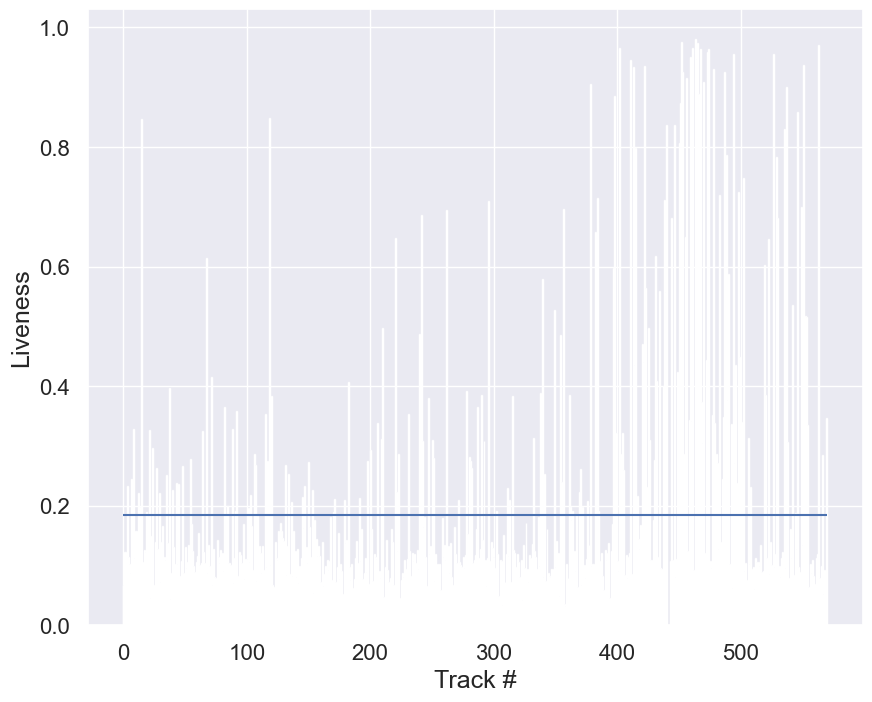

In [85]:
def inspect(df, param, cluster):
    plt.figure(figsize=(10,8))
    test_cluster = df.loc[df['Cluster'] == cluster]
    y = test_cluster[param]
    x = [i for i in range(len(y))]
    plt.bar(x, y)
    plt.xlabel('Track #', fontsize=18)
    plt.ylabel(param.title(), fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.hlines(np.mean(df[param]), 0, len(y))
    plt.show()
    
inspect(df, "liveness", 4)

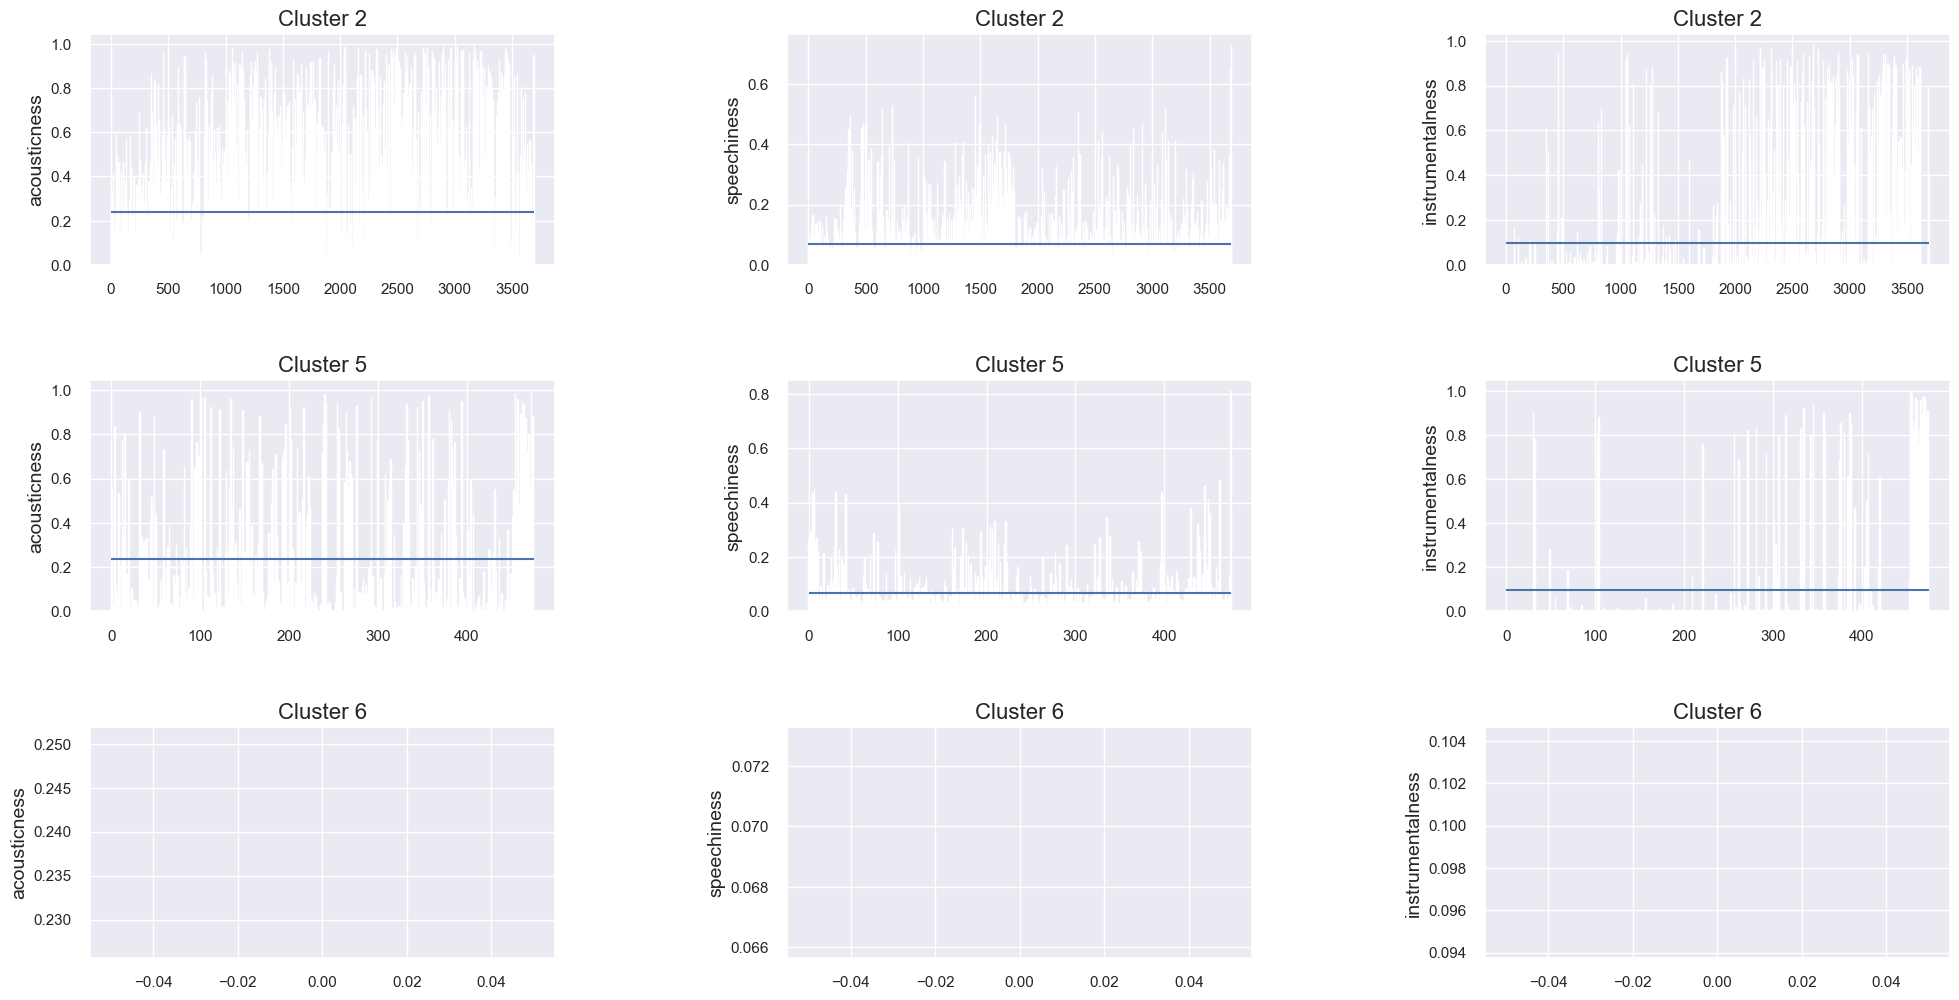

In [86]:
clusters = [2, 5, 6]
features = ["acousticness", "speechiness", "instrumentalness"]
colors = ['tab:green', 'tab:olive', 'tab:cyan']
dim = len(clusters)

fig, axes = plt.subplots(dim, dim, figsize=(24, 12))
i = 0
test_cluster = df.loc[df['Cluster'] == clusters[0]]
for ax in (axes.flatten()):
    if i % dim == 0 and i != 0:
        test_cluster = df.loc[df['Cluster'] == clusters[i // dim]]
    col = features[i % dim]
    y = test_cluster[col]
    x = [i for i in range(len(y))]
    ax.bar(x, y, color=colors[i//dim])
    ax.set_ylabel(col, fontsize=14)
    ax.set_title("Cluster " + str(clusters[i // dim]), fontsize=16)
    ax.hlines(np.mean(df[col]), 0, len(y))
    plt.subplots_adjust(wspace=.5, hspace=.5)
    i += 1
    
fig.savefig("./visualizations/cluster_feature_bar_charts_dim_3.png")

In [87]:
preview = df.loc[df['Cluster'] == 5]
print(len(preview))
preview.head(n=50)

475


,name,artist,track_URI,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,playlist,Cluster
62,Sorry Not Sorry,Demi Lovato,spotify:track:3Du2K5dLzmduCNp6uwuaL0,0.02230,0.702,0.635,0.000000,0.2830,-6.917,0.2650,144.004,0.8730,The Longest Playlist on Spotify® (Official),5.0
90,Trumpets,Jason Derulo,spotify:track:5KONnBIQ9LqCxyeSPin26k,0.55500,0.635,0.691,0.000000,0.0970,-4.862,0.2580,82.142,0.6380,The Longest Playlist on Spotify® (Official),5.0
109,Single Ladies (Put a Ring on It),Beyoncé,spotify:track:5R9a4t5t5O0IsznsrKPVro,0.03830,0.426,0.584,0.000000,0.1880,-5.293,0.2960,193.437,0.2720,The Longest Playlist on Spotify® (Official),5.0
163,Sunday Candy,Donnie Trumpet & The Social Experiment,spotify:track:6fTdcGsjxlAD9PSkoPaLMX,0.53000,0.511,0.596,0.000000,0.0798,-6.560,0.2240,158.063,0.5540,The Longest Playlist on Spotify® (Official),5.0
220,Love Yourself,Justin Bieber,spotify:track:50kpGaPAhYJ3sGmk6vplg0,0.83500,0.609,0.378,0.000000,0.2800,-9.828,0.4380,100.418,0.5150,The Longest Playlist on Spotify® (Official),5.0
235,No Pressure,Justin Bieber,spotify:track:10SDxx0CFWGqgVVBeX22TP,0.12100,0.644,0.595,0.000000,0.2790,-6.877,0.2150,148.889,0.5540,The Longest Playlist on Spotify® (Official),5.0
248,Like A G6,Far East Movement,spotify:track:5AyL2kgLtTWEu3qO3B9SqK,0.00676,0.435,0.837,0.000000,0.1170,-8.126,0.4490,124.913,0.7780,The Longest Playlist on Spotify® (Official),5.0
276,Wiggle (feat. Snoop Dogg),Jason Derulo,spotify:track:2sLwPnIP3CUVmIuHranJZU,0.08020,0.697,0.621,0.000000,0.1620,-6.886,0.2500,81.946,0.7210,The Longest Playlist on Spotify® (Official),5.0
391,I Like Me Better,Lauv,spotify:track:1wjzFQodRWrPcQ0AnYnvQ9,0.53500,0.752,0.505,0.000003,0.1040,-7.621,0.2530,91.970,0.4190,The Longest Playlist on Spotify® (Official),5.0
396,Till You're Loved,Mr. Probz,spotify:track:70rYp3dhUBTz9Da3OgmlA1,0.20800,0.674,0.754,0.000000,0.1640,-4.340,0.2690,101.424,0.5700,The Longest Playlist on Spotify® (Official),5.0
